### Install libraries from terminal:

Open your terminal in the project's root directory and run:

`pip install -r requirements.txt` 

This will install all the libraries listed in requirements.txt in your project's environment.

### Install Libraries from here:

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Add environment variables.

#### openai_api_key
In our configuration (.zshrc) file for Zsh (Z Shell), we add:
```bash
export OPENAI_API_KEY="your-open-ai-api-key"
```



### Import Libraries

In [1]:
# Standard Libraries
import os
import operator
import json
from IPython.display import Image, display

# Third Party Libraries
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from typing import Literal
from Models.state import State
from Models.xml_formatter import to_xml
from helpers import to_markdown, draw_graph, display_message

### Initialize an OpenAI model

In [2]:
llm = ChatOpenAI(
    temperature=0.3
)

### Validate the input

In [3]:
def validate(state):
    """
    Validates the language of the input text and updates the state.
    """
    # - Extract the phrase to be translated (`text`).
    user_input = state.messages[-1]

    prompt = f"""
    You are a highly skilled language detection expert and translation assistant.
    Your job is to determine if the {user_input} is a translation request and extract the necessary details.
    The response **must be a valid JSON object** with property name enclosed in double quotes.

    ## **Task Instructions**
    1. If the {user_input} asks for a translation using either the format "How do you say [text] in [language]?", or  "Translate [text] to [language]":
       - Set `translate = True`
       - Identify the **source language** (assume English if not stated).
       - Identify the **target language** (based on the user's request).
       - Set `text = {user_input}`

    2. If the {user_input} **is not** a translation request:
       - Set `translate = False`
       - Set `source_language = "unknown"`
       - Set `target_language = "unknown"`
       - Set `text = ""`

    ## **Example Inputs & Outputs**
    ### ✅ Example 1 (Translation request)
    **Input:** "How do you say 'get up' in Spanish?"  
    **Expected Output:**

    ```json
    {
        {
        "source_language": "en",
        "target_language": "es",
        "translate": True,
        "text": "How do you say 'get up' in Spanish?"
        }
    }
    ```

    ### ✅ Example 2 (Translation request)
    **Input:** "Translate 'get up' to Spanish"  
    **Expected Output:**

    ```json
    {
        {
        "source_language": "en",
        "target_language": "es",
        "translate": True,
        "text": "Translate 'get up' to Spanish"
        }
    }
    ```

    ### ❌ Example 3 (Not a translation request)
    **Input:** "What is the weather like today?"
    **Expected Output:**

    ```json
    {
        {
        "source_language": "unknown",
        "target_language": "unknown",
        "translate": False,
        "text": ""
        }
    }
    ```
    """

    user = HumanMessage(content=prompt)
    state.messages.append(user)
    ai_message = llm.invoke([user])
    state.add_validation_state(ai_message)
    return state
    

### Translate

In [4]:
def translate(state):
    """
    Translate text from the source language to the target language of a given text.
    """
    text_to_translate = state.validation.text_to_translate()
    
    if text_to_translate is None:
        return
    
    source_language = state.validation.source_language
    target_language = state.validation.target_language
    
    given_text = state.validation.text
    
    prompt = f"""
    You are a world-class translator. Translate the given text from {source_language} to {target_language}.
    ### **Given text:**  
    {text_to_translate}  
    
    ### **Response Format:**  
    The response **must be a valid JSON object** with property names enclosed in double quotes with this structure: 
    
    {
        {
        "given_text": "{given_text}",
        "translated_text": "<translated_text_here>"
        }
    }

    """
    user = HumanMessage(content=prompt)
    state.messages.append(user)
    ai_message = llm.invoke([user])
    state.add_translation_state(ai_message)
    return state
    

### Route Chooser

In [5]:
def route_chooser(state) -> Literal["translator", END]:
    display(to_markdown(f"#### Route Chooser (conditional_edges) ...\n---"))
    if state.validation.translate:
        return "translator"
    else:
        state.display_no_translate_prompt_msg()
        return END

### Create the graph

In [6]:
graph = StateGraph(State)

# Nodes
graph.add_node("validator", validate)
graph.add_node("translator", translate)
graph.add_node("formatter", to_xml)

# Edges or Conditional Edges
graph.add_edge(START, "validator")
graph.add_edge("translator", "formatter")
graph.add_conditional_edges("validator", route_chooser)
graph.add_edge("formatter", END)

app = graph.compile()

### Display the graph

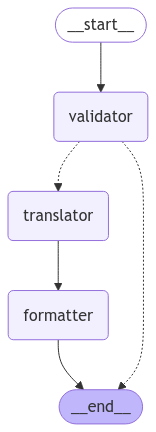

In [7]:
draw_graph(app)

### Reset app

In [8]:
def reset_app():
    state = State(
        messages=[],
        validation=None,
        translation=None
    )
    thread = {"configurable": {"thread_id": None}}


### Run the app

In [9]:
def run_app(content, thread_id):
    """
    Executes a process within the app by resetting the application state, 
    initializing a new state with a given message, and invoking the app with the state.

    Parameters:
    content (str): The message content to be processed.
    thread_id (str): The identifier for the thread in which the process runs.

    Returns:
    None
    """
    reset_app()
    state = State(
        messages=[HumanMessage(content=content)],
        validation=None,
        translation=None
    )
    thread = {"configurable": {"thread_id": thread_id}}
    response = app.invoke(state, thread)  # Call the app with the updated state
    display(to_markdown(f"#### END\n ---")) 

### Enjoy the app

In [10]:
message = f"""
</br></br>🌍✨ **You are interacting with a translation assistant.**</br></br>

To get the best results, please format your request like one of the following examples:</br></br>  

1️⃣ **How do you say [text] in [language]?**</br></br>  
    📝Example: *"How do you say thank you in French?"*  </br></br>

2️⃣ **Translate [text] to [language]**</br></br> 
   📝 Example: *"Translate hello to Spanish"*  </br></br>  

💡📖 Thank you for using the translation service! 😊🌟
"""
display_message("⚠️ **Notice:** ⚠️", message)

> ---
> ⚠️ **Notice:** ⚠️
> </br></br>🌍✨ **You are interacting with a translation assistant.**</br></br>
> To get the best results, please format your request like one of the following examples:</br></br>
> 1️⃣ **How do you say [text] in [language]?**</br></br>
> 📝Example: *"How do you say thank you in French?"*  </br></br>
> 2️⃣ **Translate [text] to [language]**</br></br>
> 📝 Example: *"Translate hello to Spanish"*  </br></br>
> 💡📖 Thank you for using the translation service! 😊🌟
> ---

### Example 1

In [11]:
run_app("How do you say AI Agent in Spanish?", "1")

> ---
> #### START
> ---

> #### Validator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "How do you say AI Agent in Spanish?",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={}`\n\n    2. If the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"en\",\n    \"target_language\": \"es\",\n    \"translate\": true,\n    \"text\": \"How do you say AI Agent in Spanish?\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 39,
> "prompt_tokens": 486,
> "total_tokens": 525,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-a2b21f58-7f19-4617-a2c2-85505e5bf93e-0"
> }
> ],
> "validation": {
> "source_language": "en",
> "target_language": "es",
> "translate": true,
> "text": "How do you say AI Agent in Spanish?"
> },
> "translation": null
> }
> ```

> ---

> #### Route Chooser (conditional_edges) ...
> ---

> #### Translator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "How do you say AI Agent in Spanish?",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={}`\n\n    2. If the content='How do you say AI Agent in Spanish?' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"en\",\n    \"target_language\": \"es\",\n    \"translate\": true,\n    \"text\": \"How do you say AI Agent in Spanish?\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 39,
> "prompt_tokens": 486,
> "total_tokens": 525,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-a2b21f58-7f19-4617-a2c2-85505e5bf93e-0"
> },
> {
> "content": "\n    You are a world-class translator. Translate the given text from en to es.\n    ### **Given text:**  \n    AI Agent  \n    \n    ### **Response Format:**  \n    The response **must be a valid JSON object** with property names enclosed in double quotes with this structure: \n    \n    {'given_text': '{given_text}', 'translated_text': '<translated_text_here>'}\n\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"given_text\": \"AI Agent\",\n    \"translated_text\": \"Agente de IA\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 23,
> "prompt_tokens": 86,
> "total_tokens": 109,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-91d5457c-849d-4ffb-ac53-8fd0c25bd225-0"
> }
> ],
> "validation": {
> "source_language": "en",
> "target_language": "es",
> "translate": true,
> "text": "How do you say AI Agent in Spanish?"
> },
> "translation": {
> "given_text": "AI Agent",
> "translated_text": "Agente de IA"
> }
> }
> ```

> ---

> #### Formatter:
> ---

> ```xml
> <content>
> <original>How do you say AI Agent in Spanish?</original>
> <translation>Agente de IA</translation>
> </content>
> ```

> ```xml
> <?xml version="1.0" ?>
> <content>
> <original>How do you say AI Agent in Spanish?</original>
> <translation>Agente de IA</translation>
> </content>
> ```
> ---

> #### END
> ---

### Example 2

In [12]:
run_app("How are you?", "2")

> ---
> #### START
> ---

> #### Validator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "How are you?",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='How are you?' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='How are you?' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='How are you?' additional_kwargs={} response_metadata={}`\n\n    2. If the content='How are you?' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"unknown\",\n    \"target_language\": \"unknown\",\n    \"translate\": false,\n    \"text\": \"\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 30,
> "prompt_tokens": 466,
> "total_tokens": 496,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-c2a418c4-c467-446e-aca1-572fd0f3ca23-0"
> }
> ],
> "validation": {
> "source_language": "unknown",
> "target_language": "unknown",
> "translate": false,
> "text": ""
> },
> "translation": null
> }
> ```

> ---

> #### Route Chooser (conditional_edges) ...
> ---

> ---
> ⚠️ **Notice:** ⚠️
> </br></br>Please remember, this assistant is designed **specifically for translation purposes** 🌍📝.
> For the best experience, please ensure your queries are related to translating text between languages.
> Other types of queries may not be processed correctly. ❌🤖</br></br>
> ✅ Thank you for understanding! 😊🙏
> ---
> ---

> #### END
> ---

### Example 3

In [13]:
run_app("Translate How do you feel in German", "3")

> ---
> #### START
> ---

> #### Validator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "Translate How do you feel in German",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='Translate How do you feel in German' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='Translate How do you feel in German' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='Translate How do you feel in German' additional_kwargs={} response_metadata={}`\n\n    2. If the content='Translate How do you feel in German' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"en\",\n    \"target_language\": \"de\",\n    \"translate\": true,\n    \"text\": \"Translate How do you feel in German\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 38,
> "prompt_tokens": 482,
> "total_tokens": 520,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-2142e1d0-89dc-48f5-b269-af4e12cee7b0-0"
> }
> ],
> "validation": {
> "source_language": "en",
> "target_language": "de",
> "translate": true,
> "text": "Translate How do you feel in German"
> },
> "translation": null
> }
> ```

> ---

> #### Route Chooser (conditional_edges) ...
> ---

> ---
> ❌ **Error Message:** ❌
> </br></br>🚨 Please use the format:</br>
> 🔹 **How do you say [text] in [language]?**</br>
> 🔹 **Translate [text] to [language]**</br>
> 📝 Example: *How do you say 'hello' in Spanish?* 🌍</br>
> ⚠️ Incorrect formats may not be processed. Please try again! 🙏😊
> ---
> ---

> #### END
> ---

### Example 4

In [14]:
run_app("Translate How do you feel to German", "4")

> ---
> #### START
> ---

> #### Validator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "Translate How do you feel to German",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='Translate How do you feel to German' additional_kwargs={} response_metadata={}`\n\n    2. If the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"en\",\n    \"target_language\": \"de\",\n    \"translate\": true,\n    \"text\": \"Translate How do you feel to German\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 38,
> "prompt_tokens": 482,
> "total_tokens": 520,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-4ed148a9-06fb-4c1c-b4ff-c3337d0ab8a6-0"
> }
> ],
> "validation": {
> "source_language": "en",
> "target_language": "de",
> "translate": true,
> "text": "Translate How do you feel to German"
> },
> "translation": null
> }
> ```

> ---

> #### Route Chooser (conditional_edges) ...
> ---

> #### Translator:
> ---

> ```json
> {
> "messages": [
> {
> "content": "Translate How do you feel to German",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "\n    You are a highly skilled language detection expert and translation assistant.\n    Your job is to determine if the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} is a translation request and extract the necessary details.\n    The response **must be a valid JSON object** with property name enclosed in double quotes.\n\n    ## **Task Instructions**\n    1. If the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} asks for a translation using either the format \"How do you say [text] in [language]?\", or  \"Translate [text] to [language]\":\n       - Set `translate = True`\n       - Identify the **source language** (assume English if not stated).\n       - Identify the **target language** (based on the user's request).\n       - Set `text = content='Translate How do you feel to German' additional_kwargs={} response_metadata={}`\n\n    2. If the content='Translate How do you feel to German' additional_kwargs={} response_metadata={} **is not** a translation request:\n       - Set `translate = False`\n       - Set `source_language = \"unknown\"`\n       - Set `target_language = \"unknown\"`\n       - Set `text = \"\"`\n\n    ## **Example Inputs & Outputs**\n    ### \u2705 Example 1 (Translation request)\n    **Input:** \"How do you say 'get up' in Spanish?\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"How do you say 'get up' in Spanish?\"}\n    ```\n\n    ### \u2705 Example 2 (Translation request)\n    **Input:** \"Translate 'get up' to Spanish\"  \n    **Expected Output:**\n\n    ```json\n    {'source_language': 'en', 'target_language': 'es', 'translate': True, 'text': \"Translate 'get up' to Spanish\"}\n    ```\n\n    ###\u00a0\u274c Example 3 (Not a translation request)\n    **Input:** \"What is the weather like today?\"\n    **Expected Output:**\n\n    ```json\n    {'source_language': 'unknown', 'target_language': 'unknown', 'translate': False, 'text': ''}\n    ```\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"source_language\": \"en\",\n    \"target_language\": \"de\",\n    \"translate\": true,\n    \"text\": \"Translate How do you feel to German\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 38,
> "prompt_tokens": 482,
> "total_tokens": 520,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-4ed148a9-06fb-4c1c-b4ff-c3337d0ab8a6-0"
> },
> {
> "content": "\n    You are a world-class translator. Translate the given text from en to de.\n    ### **Given text:**  \n    How do you feel  \n    \n    ### **Response Format:**  \n    The response **must be a valid JSON object** with property names enclosed in double quotes with this structure: \n    \n    {'given_text': '{given_text}', 'translated_text': '<translated_text_here>'}\n\n    ",
> "additional_kwargs": {},
> "response_metadata": {},
> "type": "human",
> "name": null,
> "id": null
> },
> {
> "content": "{\n    \"given_text\": \"How do you feel\",\n    \"translated_text\": \"Wie f\u00fchlst du dich\"\n}",
> "additional_kwargs": {
> "refusal": null
> },
> "response_metadata": {
> "token_usage": {
> "completion_tokens": 27,
> "prompt_tokens": 88,
> "total_tokens": 115,
> "completion_tokens_details": {
> "accepted_prediction_tokens": 0,
> "audio_tokens": 0,
> "reasoning_tokens": 0,
> "rejected_prediction_tokens": 0
> },
> "prompt_tokens_details": {
> "audio_tokens": 0,
> "cached_tokens": 0
> }
> },
> "model_name": "gpt-3.5-turbo-0125",
> "system_fingerprint": null,
> "finish_reason": "stop",
> "logprobs": null
> },
> "type": "ai",
> "name": null,
> "id": "run-89128efb-22a2-4b61-adea-98088d3d89e4-0"
> }
> ],
> "validation": {
> "source_language": "en",
> "target_language": "de",
> "translate": true,
> "text": "Translate How do you feel to German"
> },
> "translation": {
> "given_text": "How do you feel",
> "translated_text": "Wie f\u00fchlst du dich"
> }
> }
> ```

> ---

> #### Formatter:
> ---

> ```xml
> <content>
> <original>Translate How do you feel to German</original>
> <translation>Wie fühlst du dich</translation>
> </content>
> ```

> ```xml
> <?xml version="1.0" ?>
> <content>
> <original>Translate How do you feel to German</original>
> <translation>Wie fühlst du dich</translation>
> </content>
> ```
> ---

> #### END
> ---